In [27]:
from gensim.models import fasttext
from gensim.models import FastText
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

origin_train = './train_data/'
origin_test = './test_data/'

In [2]:
corpus = pd.read_csv(origin_train + 'corpus.csv')
corpus

,quechua
0,Quchakuna: Kivu qucha
1,Runakunaqa uywakunapas ñawinkunawanmi rikun. R...
2,Commons nisqaqa multimidya kapuyninkunayuqmi k...
3,NaN
4,Commons nisqaqa multimidya kapuyninkunayuqmi k...
...,...
178960,"Ellos son hechiceros, ch'eqmiseros228, brujos229."
178961,6 ñiqin hatun puquy killapi 337 watapimanta 12...
178962,Kuyuylla karu rimanapaq rikuriy
178963,Haki distritu (kastilla simipi: Distrito de Ja...


In [3]:
sufixes = pd.read_csv(origin_train + 'sufixes.csv')
sufixes

,sufix
0,cha
1,chaw
2,chi
3,chka
4,chra
...,...
69,yoq
70,ysi
71,yuq
72,ña


## Preprocesamiento

In [4]:
def remove_sufixes(word,sufixes):
  for suffix in sufixes:
    if word.endswith(suffix):
      return word[:-len(suffix)]
  return word

def remove_empty_strings_rows(df,column):
  return df[df[column].str.strip().astype(bool)]

def remove_invalid_word(word):
    # Check if the word contains any digits
    if re.search(r'\d', word):
        return ''
    
    # Check if the word contains only allowed characters (a-z, ñ, apostrophes, and spaces)
    if not re.match(r"^[a-zñA-ZÑ' ]*$", word):
        return ''
    
    # Check if the word contains any of the unwanted characters: b, d, e, f, g, j, o, v, x, z
    if re.search(r"[bdefgjovxzBDEFGJOVXZ]", word):
        return ''
    
    return word

def clean_df(cad):
    text = cad.lower()
    text = " ".join(text.split())
    text = text.replace('´',"'")
    
    tokenizer = RegexpTokenizer(r"[a-zA-Z0-9']+(?:\w*)")
    text = tokenizer.tokenize(text)
    words = [remove_sufixes(word,sufixes['sufix']) for word in text]
    words = [remove_invalid_word(word) for word in words]
    result = " ".join(words)
    result = ' '.join(result.split())
    return result.split()

In [5]:
corpus['quechua'] = remove_empty_strings_rows(corpus,'quechua')['quechua']
corpus.dropna(inplace=True)
corpus['quechua'] = corpus['quechua'].apply(clean_df)
corpus = corpus[corpus['quechua'].apply(lambda x: len(x) > 0)]
corpus['quechua'] = corpus['quechua'].apply(lambda list: [word for word in list if len(word) >= 3])

/tmp/ipykernel_103373/3763830319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['quechua'] = corpus['quechua'].apply(lambda list: [word for word in list if len(word) >= 3])


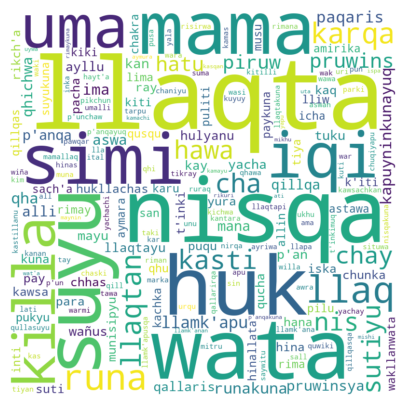

In [6]:
# Assuming 'corpus' is a DataFrame with a column 'quechua' containing lists of words
word_counts = {}
for words in corpus['quechua']:
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1

# Generate WordCloud based on frequencies
wordcloud = WordCloud(width=800, height=800, background_color="white").generate_from_frequencies(word_counts)

# Plotting the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
!curl -o ./train_data/cc.qu.300.bin.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.qu.300.bin.gz
!tar -xvf ./train_data/cc.qu.300.bin.gz

In [9]:
modelFT = fasttext.load_facebook_model(origin_train+'cc.qu.300.bin')
modelFT.build_vocab(corpus['quechua'], update=True)
modelFT.train(corpus['quechua'], total_examples=modelFT.corpus_count, epochs=15)

In [8]:
modelFT = FastText(corpus['quechua'], vector_size=150, window=5, min_count=20, workers=20, sg=1,epochs=15)
modelFT.build_vocab(corpus['quechua'])
modelFT.train(corpus['quechua'], total_examples=modelFT.corpus_count, epochs=modelFT.epochs)

(8345490, 13357335)

In [9]:
modelFT.save(origin_train+'fasttext.model')

In [10]:
modelFT.wv.most_similar_to_given('wayra',['runa','pisqu','suyo'])

'pisqu'

In [37]:
#modelFT = FastText.load(origin_train+'fasttext.model')

## Tests

In [11]:

sentiment_df = pd.read_csv(origin_test+'QuechuaCollaoCorpus.csv')
sentiment_df

,ID,N°,Tipo,T,Quechua,Traducción,Sentimiento
0,B001,1,Palabra,W,Ch’arwi,Desorden,ABURRIDO
1,B002,2,Palabra,W,Runa,Persona,ABURRIDO
2,B003,3,Palabra,W,Chanin,Precio,ABURRIDO
3,B004,4,Palabra,W,Puka,Rojo,ABURRIDO
4,B005,5,Palabra,W,Hallp’a,Tierra,ABURRIDO
...,...,...,...,...,...,...,...
2066,T226,226,Oración,S,Runakuna manan mallkikunata tarpunkuchu chaymi...,La personas no plantan árboles es uno de los f...,TRISTE
2067,T227,227,Oración,S,Erqe mamanpa wañusqanmanta waqan.,El niño llora porque su madre murió.,TRISTE
2068,T228,228,Oración,S,Huk wayna chakamanta wukchuyukusqa hinaspa wañ...,Un joven se lanzó del puente y murió.,TRISTE
2069,T229,229,Oración,S,Mama churin mana wasinman kutimusqanmanta waqan.,La madre llora porque su hijo no vuelve a la c...,TRISTE


In [12]:

dict_sentiment ={value: key for key,value in enumerate(set(sentiment_df['Sentimiento']))}
dict_sentiment

{'ADORMILADO': 0,
 'NEUTRAL': 1,
 'EMOCIONADO': 2,
 'FELIZ': 3,
 'TRISTE': 4,
 'CALMADO': 5,
 'TEMEROSO': 6,
 'ABURRIDO': 7,
 'ENOJADO': 8}

In [13]:
def group_sentiment(sentiment:str)->int:
    postive = ['EMOCIONADO','FELIZ','CALMADO']
    neutral = ['NEUTRAL','ABURRIDO','ADORMILADO']
    negative = ['TRISTE','ENOJADO','TEMEROSO']
    
    if sentiment in postive:
        return 2
    elif sentiment in neutral:
        return 1
    elif sentiment in negative:
        return 0
    else:
        raise ValueError('Sentiment not found')
        

In [14]:
sentiment_df['Label'] = sentiment_df['Sentimiento'].apply(group_sentiment)
sentiment_df

,ID,N°,Tipo,T,Quechua,Traducción,Sentimiento,Label
0,B001,1,Palabra,W,Ch’arwi,Desorden,ABURRIDO,1
1,B002,2,Palabra,W,Runa,Persona,ABURRIDO,1
2,B003,3,Palabra,W,Chanin,Precio,ABURRIDO,1
3,B004,4,Palabra,W,Puka,Rojo,ABURRIDO,1
4,B005,5,Palabra,W,Hallp’a,Tierra,ABURRIDO,1
...,...,...,...,...,...,...,...,...
2066,T226,226,Oración,S,Runakuna manan mallkikunata tarpunkuchu chaymi...,La personas no plantan árboles es uno de los f...,TRISTE,0
2067,T227,227,Oración,S,Erqe mamanpa wañusqanmanta waqan.,El niño llora porque su madre murió.,TRISTE,0
2068,T228,228,Oración,S,Huk wayna chakamanta wukchuyukusqa hinaspa wañ...,Un joven se lanzó del puente y murió.,TRISTE,0
2069,T229,229,Oración,S,Mama churin mana wasinman kutimusqanmanta waqan.,La madre llora porque su hijo no vuelve a la c...,TRISTE,0


In [15]:
sentiment_df['Quechua'] = remove_empty_strings_rows(sentiment_df,'Quechua')['Quechua']
sentiment_df.dropna(inplace=True)
sentiment_df['Quechua'] = sentiment_df['Quechua'].apply(clean_df)
sentiment_df = sentiment_df[sentiment_df['Quechua'].apply(lambda x: len(x) > 0)]
sentiment_df['Quechua'] =sentiment_df['Quechua'].apply(lambda list: [word for word in list if len(word) >= 3])

/tmp/ipykernel_103373/2422280042.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['Quechua'] =sentiment_df['Quechua'].apply(lambda list: [word for word in list if len(word) >= 3])


In [16]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.utils.rnn import pad_sequence

In [17]:
X_train, X_test, y_train, y_test = train_test_split(sentiment_df['Quechua'], sentiment_df['Label'], test_size=0.2, random_state=42,stratify=sentiment_df['Label'])

In [18]:
X_train

716                                         [tapuy]
1233                          [chanin, imata, ruwa]
969                           [kunanmanta, rimanki]
522                                    [kamachikuy]
648                 [mishk'i, uchuku, maran, kasha]
                           ...                     
1750                    [runa, anchata, manchariku]
739                       [ishka, killapi, yachasa]
177     [wanuta, phish, llamakunapi, chakra, apasu]
1840           [mana, ima, milla, kan, pisi, wañuy]
1933        [chirimanta, chaki, tulluykuna, nanawa]
Name: Quechua, Length: 1619, dtype: object

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
#RNN

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out
    

In [35]:

model = RNN(input_size=150, hidden_size=128, num_layers=3, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class QuechuaDataset(Dataset):
    def __init__(self, X, y,modelFT):
        self.X = X
        self.y = y
        self.modelFT = modelFT
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        words = self.X.iloc[idx]
        embeddings = [self.modelFT.wv[word] for word in words]
        if len(embeddings) == 0:  # Manejar secuencias vacías
            embeddings = [np.zeros(self.modelFT.vector_size)]
        return torch.tensor(embeddings), torch.tensor(self.y.iloc[idx])

In [36]:
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_paddded = pad_sequence(inputs, batch_first=True)
    return inputs_paddded.float(), torch.stack(targets)

In [38]:
train_dataset = QuechuaDataset(X_train, y_train, modelFT)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

num_epochs = 1000
print_interval = 25  # Intervalo para imprimir el progreso

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for i, (data, labels) in enumerate(train_loader):
        embeddings = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculate accuracy for the epoch
    accuracy = 100. * correct / total

    # Print progress every 50 epochs
    if (epoch + 1) % print_interval == 0 or epoch == num_epochs - 1:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

print('Finished Training')


Epoch 25/1000, Loss: 0.7740, Accuracy: 77.70%
Epoch 50/1000, Loss: 0.7603, Accuracy: 78.94%
Epoch 75/1000, Loss: 0.7820, Accuracy: 76.90%
Epoch 100/1000, Loss: 0.7613, Accuracy: 78.81%
Epoch 125/1000, Loss: 0.7577, Accuracy: 79.37%
Epoch 150/1000, Loss: 0.7433, Accuracy: 80.61%
Epoch 175/1000, Loss: 0.7661, Accuracy: 78.57%
Epoch 200/1000, Loss: 0.7529, Accuracy: 79.68%
Epoch 225/1000, Loss: 0.7269, Accuracy: 82.15%
Epoch 250/1000, Loss: 0.7217, Accuracy: 82.52%
Epoch 275/1000, Loss: 0.7156, Accuracy: 83.45%
Epoch 300/1000, Loss: 0.7137, Accuracy: 83.51%
Epoch 325/1000, Loss: 0.7144, Accuracy: 83.69%
Epoch 350/1000, Loss: 0.7085, Accuracy: 84.00%
Epoch 375/1000, Loss: 0.7080, Accuracy: 84.25%
Epoch 400/1000, Loss: 0.7077, Accuracy: 84.13%
Epoch 425/1000, Loss: 0.7078, Accuracy: 84.13%
Epoch 450/1000, Loss: 0.7050, Accuracy: 84.31%
Epoch 475/1000, Loss: 0.7076, Accuracy: 84.25%
Epoch 500/1000, Loss: 0.7073, Accuracy: 84.19%
Epoch 525/1000, Loss: 0.7378, Accuracy: 81.22%
Epoch 550/1000, 

In [40]:
test_dataset = QuechuaDataset(X_test, y_test, modelFT)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_loader:
        embeddings = data.to(device)
        labels = labels.to(device)
        outputs = model(embeddings)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


Accuracy on the test set: 40.74%
